# C3S_422_Lot2 Plymouth Marine Laboratory: Marine, Coastal and Fisheries Sectoral Information Systems. #
# Marine Spatial Planning Demonstrator tutorial.  #

Stakeholders will be provided with an example of how climate modelling can be used in Marine Spatial Planning (MSP) based on the approach developed for the MSP of the North Sea region during the EU research programme VECTORS (Queirós et al 2016). 

The data used for processing and visualisation in this training example will be the outputs of the coupled physical biogeochemical model used to derive Tier I indicators (sea surface temperature, mean chlorophyll in the euphotic layer). In addition, the GIS positions of the Greek MPAs and important fishing grounds can be used as a fully developed example.

The presented method will require manipulating modelling simulations (Tier I and II), analysis of the selected projections, and the additional co-mapping of GIS data onto the model analysis visualisations. Key steps towards such an analysis will therefore include:

1. Model output domain selection
1. Summary statistics 
1. Model meta-analysis statistics calculation
1. GIS data co-mapping

This Jupyter Notebook contains the Python code required to carry out these steps. No knowledge of Python is required to run the notebook.


First we have to import the Python packages used in the processing.

In [1]:
from netCDF4 import Dataset,default_fillvals
from numpy import array, where, tile, log10, sqrt
from numpy.ma import array as marray
from numpy.ma import masked_where
import matplotlib.pyplot as plt
import sys, os

Define a helper function to write out the various intermediate files we generate during the procesing

In [2]:
# function to open output file and write general attributes, grid information
def open_output_file(outfilename,lon,lat,ntime,reg_name):
    print('Creating '+outfilename+'...')
    nc=Dataset(outfilename,'w',format='NETCDF3_CLASSIC')
    nc.createDimension('time',ntime)
    nc.createDimension('lat',len(lat))
    nc.createDimension('lon',len(lon))
    nc.title='%s data prepared for meta-analysis' % reg_name
    nc.source="PolcomsErsem model on combined European GCOMS domains. POLCOMS-AMM v6.3 and ERSEM 15.06."
    nc.references="For info about ERSEM see Butenschon et al. 2016, Geosci. Model Dev., 9, 1293-1339. For GCOMS see Holt et al. 2009, Phil. Trans. R. Soc. 367,939-951."
    # write grid info
    nc.createVariable('lat','f4',('lat',),zlib=True)
    nc.variables['lat'].units='degrees_north'
    nc.variables['lat'].long_name='Latitude at SW corner of cell'
    nc.createVariable('lon','f4',('lon',),zlib=True)
    nc.variables['lon'].units='degrees_east'
    nc.variables['lon'].long_name='Longitude at SW corner of cell'
    # set grid variable values
    nc.variables['lat'][:]=lat
    nc.variables['lon'][:]=lon
    return nc


## 1. Model output domain selection ##
Select simulations covering Greek territorial waters (to 12 nautical miles), coordinates of grid: 34.6° to 41.1°N and 19.1° to 28.5°E, and years 2000-2019, and 2040-2059: processing of model simulations to select the correct spatial and temporal domain required for analysis. 



In [3]:
# Step 0: Set file locations, temporal and geographic data ranges

# variables to be processed - two needed
vblist = ['SST','euphotic_layer_log-chl']
print('Processing variables',(',').join(vblist))

# location of POLCOMS-ERSEM files
model_file_dir = '/var/data/CERES_fixed_depth'

# location to save output files
outdir = '../../data/MSP'
indir = '../../data/MSP'

# Set region to output
reg_name = 'Greece'
lat_min = 34.6
lat_max = 41.1
lon_min = 19.1
lon_max = 28.5

# Set model scenarios
run_list = ['rcp85','rcp45']

# periods to extract: start year and length of period
start_yrs = [2006,2040]
nyrs = 10

# names for variables in POLCOMS-ERSEM files
model_vbname = {'SST':'thetao','euphotic_layer_log-chl':'euphotic_chl'}
# model filenames
model_fname = {'SST':'C3S-MCF_CERES_monthly','euphotic_layer_log-chl':'C3S-MCF_CERES_monthly'}

# read model grid from sample file (lon and lat as 1d arrays)
infilename = model_file_dir+'/rcp45_2006-2099/2006/C3S-MCF_CERES_monthly.rcp45.2006.01.nc'
if not os.path.isfile(infilename):
    print('Could not find input file', infilename)
    sys.exit(1)
nc = Dataset(infilename,'r')
lon = nc.variables['lon'][:]
lat = nc.variables['lat'][:]
# read fill value used for masked data
fv = nc.variables[model_vbname[vblist[0]]][:].fill_value
nc.close()

# set fill value to use for masked data
fv = default_fillvals['f8']

# find region required for output - as set by lat_min etc
jmin = where(abs(lat-lat_min)<0.05)[0][0]
jmax = where(abs(lat-lat_max)<0.05)[0][0]
imin = where(abs(lon-lon_min)<0.05)[0][0]
imax = where(abs(lon-lon_max)<0.05)[0][0]
print('Extracting data for range: latitude %.1f to %.1f N, lonitude %.1f to %.1f E' % (lat[jmin], lat[jmax], lon[imin], lon[imax]))
print('Coordinate values: y %d to %d, x %d to %d' %(jmin, jmax, imin, imax))
ny = jmax+1-jmin
nx = imax+1-imin

Processing variables SST,euphotic_layer_log-chl
Extracting data for range: latitude 34.6 to 41.1 N, lonitude 19.1 to 28.5 E
Coordinate values: y 237 to 302, x 403 to 497


We can now process this Tier 1 data to create the spatial and temporal subsets for analysis.  
These are saved to an intermediate file.


In [12]:
# Step 1: Read input data, select correct spatial and temporal range and save file
# This would need a separate section of codes to read and extract the required data, but for today we are going to use pre-prepared files instead.
!cp /var/data/CERES_fixed_depth/Greece_subsets/Greece_SST_for_analysis.nc  ../../data/MSP
!cp /var/data/CERES_fixed_depth/Greece_subsets/Greece_euphotic_layer_log-chl_for_analysis.nc ../../data/MSP

Greece_euphotic_layer_log-chl_for_analysis.nc  Greece_summary_stats1.nc
Greece_Hedges-g.nc			       Greece_summary_stats.nc
Greece_SST_for_analysis.nc		       shapefiles


## 2. Summary statistics ##
Having created a subset of the data we can now produce some summary statistics.  
In this case we calculate the 
- mean per grid cell, over a time-slice (2000-2019; 2040-2059)
- standard deviation per grid cell, over a time-slice (2000-2019; 2040-2059) 
- number of observations per grid cell, over a time-slice (2000-2019; 2040-2059) 

The calculation of the summary statistics from the model simulations selected above will be performed in a spatial context, which represents the specific occurrences of the system that we want to analyse. Therefore, the selected summary statistics will be the mean, the standard deviation, and how many times the model was sampled to calculate those, for each of the two variables modelled (sea surface temperature, mean chlorophyll in the euphotic layer), in each model grid cell, for the two periods we want to compare (i.e. present time (2000-2019) and a mid-term future (2040-2059)). 

These data are stored in an intermediate file for further visualisation and processing. 

In [13]:
# Step 2: Read the netCDF files from step1, calculate summary statistics (mean, standard deviation and number of time points at each grid cell for each variable); save in one netCF file; create and store visualisation.

# name of file for output
statsfilename = outdir+'/%s_summary_stats.nc' % (reg_name)
 
# collect grid info from one input file
infilename = indir+'/%s_%s_for_analysis.nc' % (reg_name,vblist[0])

# open file for output 
# Use calculated lon and lat to match the extracted files.
ncout = open_output_file(statsfilename,lon[imin:imax+1],lat[jmin:jmax+1],1,reg_name)

# read variable data, calculate summary statistics and save to file
for vbname in vblist:
    print('Processing',vbname)
    # open prepared file with data collected for analysis
    infilename = indir+'/%s_%s_for_analysis.nc' % (reg_name,vbname)
    ncin = Dataset(infilename,'r')
    #for each run and period find mean and stdev
    for run in run_list:
        for yr_st in start_yrs:
            set_name = '%s_%d-%d' % (run,yr_st,yr_st+nyrs-1)
            vbset = ncin.variables[vbname+'_'+set_name][:]
            vbset = masked_where(vbset==fv,vbset)
            vbmean = vbset.mean(axis=0)
            vbstd = vbset.std(axis=0)
            vbunits = ncin.variables[vbname+'_'+set_name].units
            vblong = ncin.variables[vbname+'_'+set_name].long_name
            # write mean and st dev to file
            ncout.createVariable(vbname+'_mean_'+set_name,'f8',('lat','lon',),fill_value=fv)
            ncout.variables[vbname+'_mean_'+set_name].units = vbunits
            ncout.variables[vbname+'_mean_'+set_name].long_name = vblong+', mean for %d months' % len(vbset)
            ncout.variables[vbname+'_mean_'+set_name][:] = where(vbmean.mask,fv,vbmean)
            ncout.createVariable(vbname+'_stdev_'+set_name,'f8',('lat','lon',),fill_value=fv)
            ncout.variables[vbname+'_stdev_'+set_name].units = vbunits
            ncout.variables[vbname+'_stdev_'+set_name].long_name = vblong+', standard deviation for %d months' % len(vbset)
            ncout.variables[vbname+'_stdev_'+set_name][:] = where(vbstd.mask,fv,vbstd)
            ncout.createVariable(vbname+'_ntime_'+set_name,'f8',('lat','lon',),fill_value=fv)
            ncout.variables[vbname+'_ntime_'+set_name].long_name = 'number of time points'
            ncout.variables[vbname+'_ntime_'+set_name][:] = len(vbset)
    ncin.close()
ncout.close()

print('Summary stats written to',statsfilename)


Creating ../../data/MSP/Greece_summary_stats.nc...
Processing SST
Processing euphotic_layer_log-chl
Summary stats written to ../../data/MSP/Greece_summary_stats.nc


We can now create a visualisation of the summary data.

Plotting SST rcp45 ...
Plotting SST rcp85 ...
Plotting euphotic_layer_log-chl rcp45 ...
Plotting euphotic_layer_log-chl rcp85 ...


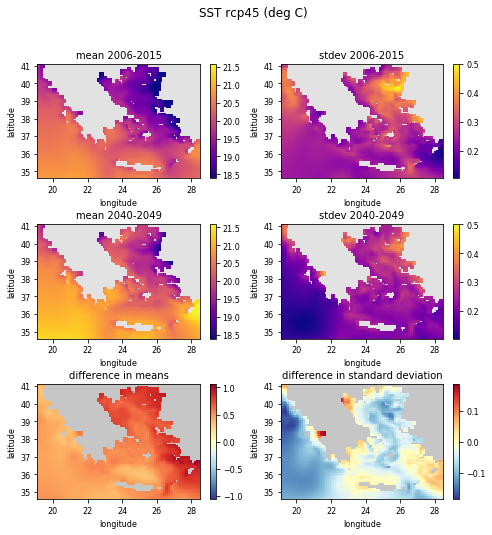

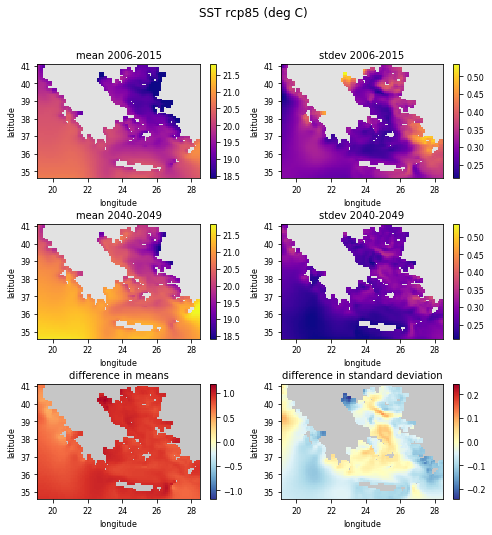

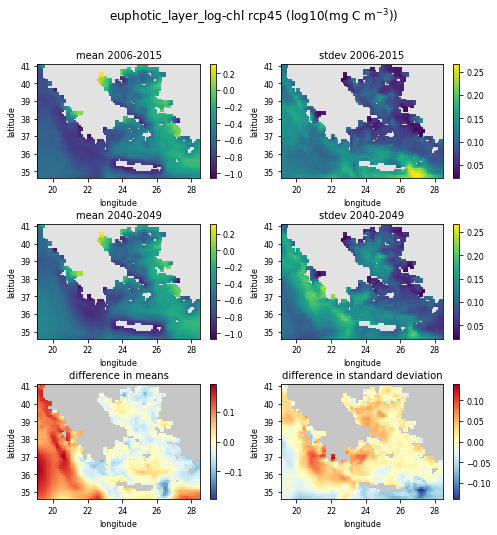

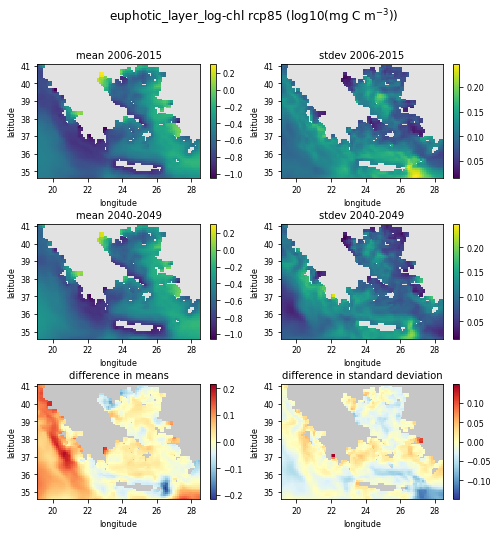

In [15]:
# create and save visualisation of the present and future means and standard deviations

# set figure size and other parameters for plotting
figsize = (8,8)
# set preferred color scheme
color_map = {'SST':'plasma','euphotic_layer_log-chl':'viridis','diff':'RdYlBu_r'}

# set font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# open file saved in previous step
nc = Dataset(statsfilename,'r')
lon = nc.variables['lon'][:]
lat = nc.variables['lat'][:]

# these lines set plotting options and create plots
for vbname in vblist:
    for run in ['rcp45','rcp85']:
        print('Plotting',vbname,run,'...')
        # read mean and standard deviation from file
        # "1" refers to the future period and "2" to the present
        vbdat = nc.variables['%s_mean_%s_%d-%d' % (vbname,run,start_yrs[1],start_yrs[1]+nyrs-1)][:]
        vbmean1 = masked_where(vbdat==fv,vbdat)
        vbdat = nc.variables['%s_stdev_%s_%d-%d' % (vbname,run,start_yrs[1],start_yrs[1]+nyrs-1)][:]
        vbsd1 = masked_where(vbdat==fv,vbdat)
        vbdat = nc.variables['%s_mean_%s_%d-%d' % (vbname,run,start_yrs[0],start_yrs[0]+nyrs-1)][:]
        vbmean2 = masked_where(vbdat==fv,vbdat)
        vbdat = nc.variables['%s_stdev_%s_%d-%d' % (vbname,run,start_yrs[0],start_yrs[0]+nyrs-1)][:]
        vbsd2 = masked_where(vbdat==fv,vbdat)
        vbunits = nc.variables['%s_mean_%s_%d-%d' % (vbname,run,start_yrs[0],start_yrs[0]+nyrs-1)].units
        # set ranges to use for plotting
        vmin_mean = max(vbmean1.min(),vbmean2.min())
        vmax_mean = max(vbmean1.max(),vbmean2.max())
        vmin_std = max(vbsd1.min(),vbsd2.min())
        vmax_std = max(vbsd1.max(),vbsd2.max())
        vmax_diffmean = max(abs(vbmean1-vbmean2).min(),abs(vbmean1-vbmean2).max())
        vmax_diffstd = max(abs(vbsd1-vbsd2).min(),abs(vbsd1-vbsd2).max())
        # create plot
        fig,axlist = plt.subplots(nrows=3,ncols=2,figsize=figsize)
        fig.suptitle('%s %s (%s)' % (vbname,run,vbunits))
        fig.subplots_adjust(hspace=0.4,wspace=0.2)
        # present day mean and standard deviation
        ax = axlist[0,0]
        ax.set_xlim(lon.min(),lon.max())
        ax.set_ylim(lat.min(),lat.max())
        ax.set_xlabel('longitude')
        ax.set_ylabel('latitude')
        im_mask = ax.pcolormesh(lon,lat,vbmean2.mask,cmap='Greys',vmax=5) 
        im = ax.pcolormesh(lon,lat,vbmean2,cmap=color_map[vbname],vmin=vmin_mean,vmax=vmax_mean)
        cb = fig.colorbar(im,ax=ax)
        ax.set_title('mean %d-%d' % (start_yrs[0],start_yrs[0]+nyrs-1))
        ax = axlist[0,1]
        ax.set_xlim(lon.min(),lon.max())
        ax.set_ylim(lat.min(),lat.max())
        ax.set_xlabel('longitude')
        ax.set_ylabel('latitude')
        im_mask = ax.pcolormesh(lon,lat,vbmean2.mask,cmap='Greys',vmax=5) 
        im = ax.pcolormesh(lon,lat,vbsd2,cmap=color_map[vbname],vmin=vmin_std,vmax=vmax_std)
        fig.colorbar(im,ax=ax)
        ax.set_title('stdev %d-%d' % (start_yrs[0],start_yrs[0]+nyrs-1))
        # future mean and standard deviation
        ax = axlist[1,0]
        ax.set_xlim(lon.min(),lon.max())
        ax.set_ylim(lat.min(),lat.max())
        ax.set_xlabel('longitude')
        ax.set_ylabel('latitude')
        im_mask = ax.pcolormesh(lon,lat,vbmean1.mask,cmap='Greys',vmax=5) 
        im = ax.pcolormesh(lon,lat,vbmean1,cmap=color_map[vbname],vmin=vmin_mean,vmax=vmax_mean)
        fig.colorbar(im,ax=ax)
        ax.set_title('mean %d-%d' % (start_yrs[1],start_yrs[1]+nyrs-1))
        ax = axlist[1,1]
        ax.set_xlim(lon.min(),lon.max())
        ax.set_ylim(lat.min(),lat.max())
        ax.set_xlabel('longitude')
        ax.set_ylabel('latitude')
        im_mask = ax.pcolormesh(lon,lat,vbsd1.mask,cmap='Greys',vmax=5) 
        im = ax.pcolormesh(lon,lat,vbsd1,cmap=color_map[vbname],vmin=vmin_std,vmax=vmax_std)
        fig.colorbar(im,ax=ax)
        ax.set_title('stdev %d-%d' % (start_yrs[1],start_yrs[1]+nyrs-1))
        # difference
        ax = axlist[2,0]
        ax.set_xlim(lon.min(),lon.max())
        ax.set_ylim(lat.min(),lat.max())
        ax.set_xlabel('longitude')
        ax.set_ylabel('latitude')
        im_mask = ax.pcolormesh(lon,lat,vbmean1.mask,cmap='Greys',vmax=3)
        im = ax.pcolormesh(lon,lat,vbmean1-vbmean2,cmap=color_map['diff'],vmin=-vmax_diffmean,vmax=vmax_diffmean)
        fig.colorbar(im,ax=ax)
        ax.set_title('difference in means')
        ax = axlist[2,1]
        ax.set_xlim(lon.min(),lon.max())
        ax.set_ylim(lat.min(),lat.max())
        ax.set_xlabel('longitude')
        ax.set_ylabel('latitude')
        im_mask = ax.pcolormesh(lon,lat,vbsd1.mask,cmap='Greys',vmax=3) 
        im = ax.pcolormesh(lon,lat,vbsd1-vbsd2,cmap=color_map['diff'],vmin=-vmax_diffstd,vmax=vmax_diffstd)
        fig.colorbar(im,ax=ax)
        ax.set_title('difference in standard deviation')    
        fig.savefig('%s_%s_changes_mean_std_%s.png' % (reg_name,vbname,run))
nc.close()

**Figure 1.** Coloured scaled visualisation derived from the comparison of summary statistics between the present and future time-slices.  
The variables shown are sea surface temperature and chlorophyll for the emissions scenarios RCP 4.5 & 8.5.  
The top row of each section shows the mean for the present day, 2000-2019, and standard deviation of annual means. The middle row shows the mean and standard deviation for 2040-2059 and the bottom row shows the difference, future-present day.

## 3. Model meta-analysis statistics calculation ##
Here we calculate the Hedge’s g for each of the variables extracted earlier.  
The calculation of specific statistics will allow us to estimate the change in each of the modelled variables over space and time.  
A common statistic used in that framework is Hedges’ g (Hedges et al. 1999), the unbiased standardized mean difference estimator. The g will be calculated for each modelled variable included in the analysis (temperature and mean chlorophyll in the euphotic layer), comparing two time slices in each model grid cell. The advantage of calculating such a statistic is that many variables with different ranges can be included simultaneously in an ecosystem-scaled analysis. 

## Calculate Hedges' g ##

The formula to calculate Hedges’ g, for each model grid cell, is:  

\begin{equation}
\left(1 - 
  \left(
    \frac
      {3}
      {4(\mathbf{n}_{future}+\mathbf{n}_{present}-2)-1}
  \right)
\right)
\times 
\frac
  {\mathbf{mean}_{future}-\mathbf{mean}_{present}}
  {\sqrt
      \frac{\left(\mathbf{n}_{future}-1\right)\mathbf{\sigma}_{future}+
          \left(\mathbf{n}_{present}-1\right)\mathbf{\sigma}_{present}}
       {\mathbf{n}_{future}+\mathbf{n}_{present}-2}
  }
\end{equation}
where 
- $n_{future}$ = number of observations on which future mean is calculated
- $n_{present}$ = number of observations on which present mean is calculated
- $\sigma_{future}$ = standard deviation in the future time slice
- $\sigma_{present}$ = standard deviation in the present time slice



In [16]:
# Calculate Hedge's-g for each variable. Save values and visualiations

# name for output filenames
gfilename = outdir+'/%s_Hedges-g.nc' % (reg_name)

# periods to compare
periods = ['%d-%d' % (start_yrs[0],start_yrs[0]+nyrs-1),'%d-%d' % (start_yrs[1],start_yrs[1]+nyrs-1)]


print('Calculating Hedge\'s g using data from', statsfilename)
nc = Dataset(statsfilename,'r')
lon = nc.variables['lon'][:]
lat = nc.variables['lat'][:]

# open file for output
ncout = open_output_file(gfilename,lon,lat,1,reg_name)

# calculate and save for each variable and run
for vbname in vblist:
    for run in ['rcp45','rcp85']:
        # read input data for each period and calculate Hedge's g
        # 1=future, 2=present
        n1 = nc.variables['%s_ntime_%s_%s' % (vbname,run,periods[1])][:]
        n2 = nc.variables['%s_ntime_%s_%s' % (vbname,run,periods[0])][:]
        mean1 = nc.variables['%s_mean_%s_%s' % (vbname,run,periods[1])][:]
        mean1 = masked_where(mean1==fv,mean1)
        mean2 = nc.variables['%s_mean_%s_%s' % (vbname,run,periods[0])][:]
        mean2 = masked_where(mean2==fv,mean2)
        sd1 = nc.variables['%s_stdev_%s_%s' % (vbname,run,periods[1])][:]
        sd1 = masked_where(sd1==fv,sd1)
        sd2 = nc.variables['%s_stdev_%s_%s' % (vbname,run,periods[0])][:]
        sd2 = masked_where(sd2==fv,sd2)
        vbunits = nc.variables['%s_mean_%s_%s' % (vbname,run,periods[0])].units
        vblong = nc.variables['%s_mean_%s_%s' % (vbname,run,periods[0])].long_name
        sw = sqrt(((n1-1)*(sd1**2) + (n2-1)*(sd2**2))/(n1+n2-2))
        d = (mean1-mean2)/sw
        j = 1.0-(3.0/(4*(n1+n2-2)-1))
        g = j*d
        # save means and Hedge's g
        mean1_name = '%s_mean_%s_%s' % (vbname,run,periods[1])
        ncout.createVariable(mean1_name,'f8',('lat','lon',)) 
        ncout.variables[mean1_name].units = vbunits
        ncout.variables[mean1_name].long_name = vblong
        ncout.variables[mean1_name][:] = where(mean1.mask,fv,mean1)
        mean2_name = '%s_mean_%s_%s' % (vbname,run,periods[0])
        ncout.createVariable(mean2_name,'f8',('lat','lon',)) 
        ncout.variables[mean2_name].units = vbunits
        ncout.variables[mean2_name].long_name = vblong
        ncout.variables[mean2_name][:] = where(mean2.mask,fv,mean2)
        g_name = '%s_g_%s' % (vbname,run)
        ncout.createVariable(g_name,'f8',('lat','lon'))
        ncout.variables[g_name].long_name ="Hedge's g for %s, %s, %s and %s" % (vbname,run,periods[1],periods[0])
        ncout.variables[g_name][:] = where(g.mask,fv,g)
nc.close()
ncout.close()

print('Processing complete')

Calculating Hedge's g using data from ../../data/MSP/Greece_summary_stats.nc
Creating ../../data/MSP/Greece_Hedges-g.nc...
Processing complete


The Hedges' g can then be visualised.

Plotting SST rcp45 ...
Plotting SST rcp85 ...
Plotting euphotic_layer_log-chl rcp45 ...
Plotting euphotic_layer_log-chl rcp85 ...


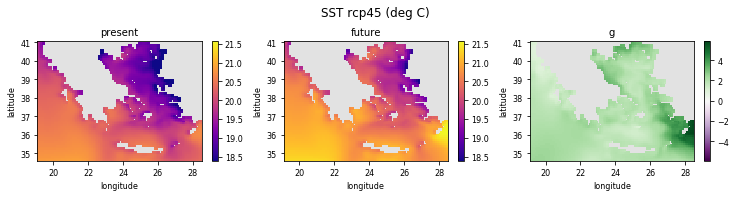

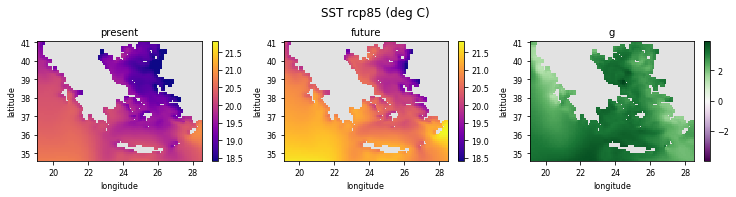

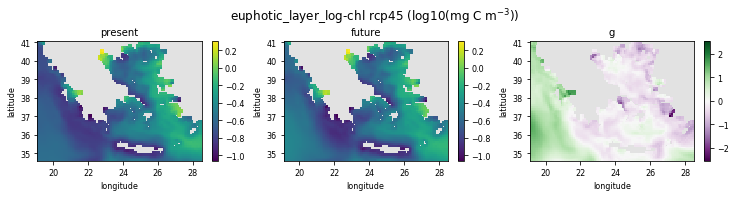

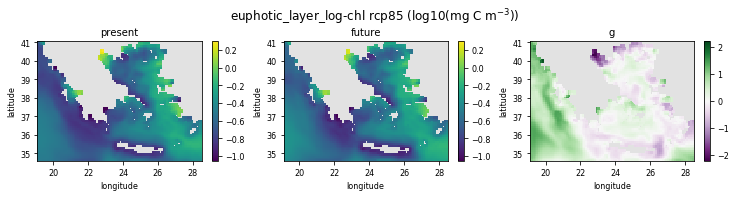

In [18]:
# create and save visualisation

# set figure size and other parameters for plotting
figsize = (12.5, 2.65)
# preferred color scheme
color_map = {'SST':'plasma','euphotic_layer_log-chl':'viridis','g':'PRGn'}
# font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title        

# open file with mean and g values, saved above
nc = Dataset(gfilename,'r')
lon = nc.variables['lon'][:]
lat = nc.variables['lat'][:]

for vbname in vblist:
    for run in ['rcp45','rcp85']:
        print('Plotting',vbname,run,'...')
        # read mean and g from file
        vbdat = nc.variables['%s_mean_%s_%s' % (vbname,run,periods[0])][:]
        mean2 = masked_where(vbdat==fv,vbdat)
        vbdat = nc.variables['%s_mean_%s_%s' % (vbname,run,periods[1])][:]
        mean1 = masked_where(vbdat==fv,vbdat)
        vbdat = nc.variables['%s_g_%s' % (vbname,run,)][:]
        g = masked_where(vbdat==fv,vbdat)
        vbunits = nc.variables['%s_mean_%s_%s' % (vbname,run,periods[0])].units
        # set ranges to use for plotting
        vmin_mean = max(mean1.min(),mean2.min())
        vmax_mean = max(mean1.max(),mean2.max())
        vmax_g = max(abs(g.min()),abs(g.max()))
        # create plot
        fig,axlist = plt.subplots(nrows=1,ncols=3,figsize=figsize)
        fig.subplots_adjust(top=0.8,bottom=0.17)
        fig.suptitle(r'%s %s (%s)' % (vbname,run,vbunits))
        # present day mean
        ax = axlist[0]
        ax.set_xlim(lon.min(),lon.max())
        ax.set_ylim(lat.min(),lat.max())
        ax.set_xlabel('longitude')
        ax.set_ylabel('latitude')
        im_mask = ax.pcolormesh(lon,lat,mean2.mask,cmap='Greys',vmax=5)         
        im = ax.pcolormesh(lon,lat,mean2,cmap=color_map[vbname],vmin=vmin_mean,vmax=vmax_mean)
        cb = fig.colorbar(im,ax=ax)
        ax.set_title('present')
        # future mean
        ax = axlist[1]
        ax.set_xlim(lon.min(),lon.max())
        ax.set_ylim(lat.min(),lat.max())
        ax.set_xlabel('longitude')
        ax.set_ylabel('latitude')
        im_mask = ax.pcolormesh(lon,lat,mean1.mask,cmap='Greys',vmax=5)
        im = ax.pcolormesh(lon,lat,mean1,cmap=color_map[vbname],vmin=vmin_mean,vmax=vmax_mean)
        cb = fig.colorbar(im,ax=ax)
        ax.set_title('future')
        # g
        ax = axlist[2]
        ax.set_xlim(lon.min(),lon.max())
        ax.set_ylim(lat.min(),lat.max())
        ax.set_xlabel('longitude')
        ax.set_ylabel('latitude')
        im_mask = ax.pcolormesh(lon,lat,mean2.mask,cmap='Greys',vmax=5)         
        im = ax.pcolormesh(lon,lat,g,cmap=color_map['g'],vmin=-vmax_g,vmax=vmax_g)
        cb = fig.colorbar(im,ax=ax)
        ax.set_title('g')
        fig.savefig('%s_g_%s_%s.png' % (reg_name,vbname,run))

nc.close()

**Figure 2.** Coloured scaled visualisation of each modelled variable derived from the comparison of the present time-slice (left), future time-slice (centre) and the Hedges’ g statistics (right).  
The top row shows sea surface temperature, the bottom row shows mean chlorophyll in the euphotic layer. For chlorophyll, the logarithm is used so that the data has an approximately normal distribution. Positive g means that the future mean is higher than present-day.

## 4. GIS data co-mapping ##
Here we co-map Greek MPAs and fishing grounds onto the Hedge’s g visualisations as created above.  
This example application will facilitate stakeholders to co-map GIS data reflecting spatial uses of the marine environment by different economic sectors onto the modelling analyses data.  
These data may be point data, polygon data or any other type of spatial data, in any given format. 

Input data: 
* Hedges’ g visualizations for each modelled variable from (3); 
* GIS shapefiles (*.shp files) reflecting spatial uses (points and polygons) of the marine environment (the location of Greek MPAs, fishing grounds and aquaculture sites will be used as an example dataset). 

This Python script co-maps the GIS data onto each Hedges’ g visualisation, allowing the observer to compare the spatial uses co-mapped with changes in the modelled variable quantified by Hedges’ g.

In [20]:
# Step 4: Map MPAs and fishing grounds on to Hedge's g maps

from numpy import genfromtxt
import shapefile
import matplotlib.path as mpl_path
from numpy import vstack, meshgrid
import numpy as np
def read_area_masks(area_list,shapedir,lon,lat):
    """
    Read shapefiles for a set of areas and create mask for each
    Arguments: 
    (1) dictionary of area names and shapefile names
    (2) path to directory containing directories of shapefiles
    (3,4) 1d arrays giving lon and lat of model domain
    Returns:
    Dictionary of area names and mask arrays
    """
    # create array with pairs of lon, lat for each model point
    nx = len(lon)
    ny = len(lat)
    lon2d, lat2d = meshgrid(lon,lat)
    reg_pts = vstack((lon2d.flatten(),lat2d.flatten())).transpose()
    # find mask for each area in input list
    area_masks = {}
    for name,fname in area_list.items():
        areafile = shapedir+'/%s/%s' % (name,fname)
        areashape = shapefile.Reader(areafile)
        vertices = areashape.shapes()[0].points
        areapath = mpl_path.Path(vertices)
        areamask = areapath.contains_points(reg_pts) 
        area_masks[name] = areamask.reshape(ny,nx)
    return area_masks

def get_mask_outline(maskIn):
    """
    Get array to outline all the areas in a mask file
    Based on code from http://stackoverflow.com/questions/24539296/outline-a-region-in-a-graph - comments are from there
    Argument is any 2d array with only two values, e.g. 0 and 1
    Returns an array containing x,y coordinates of line segments to be plotted
    Assumes that the coordinate origin is at the lower left corner of the mask
    """
    ver_seg = where(maskIn[:,1:] != maskIn[:,:-1])
    hor_seg = where(maskIn[1:,:] != maskIn[:-1,:])
    l = []
    for p in zip(*hor_seg):
        l.append((p[1], p[0]+1))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan,np.nan))
    for p in zip(*ver_seg):
        l.append((p[1]+1, p[0]))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan, np.nan))
    segments = array(l)
    segments[:,0] = lon[0] + (lon[-1]-lon[0])*segments[:,0]/maskIn.shape[1]
    segments[:,1] = lat[0] + (lat[-1]-lat[0])*segments[:,1]/maskIn.shape[0]
    return segments

Plotting SST rcp45
Plotting SST rcp85
Plotting euphotic_layer_log-chl rcp45
Plotting euphotic_layer_log-chl rcp85


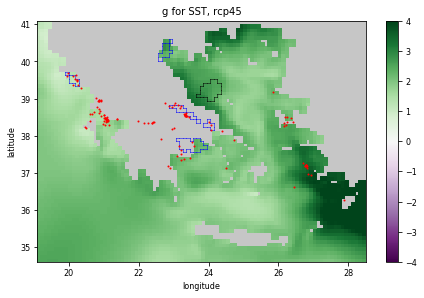

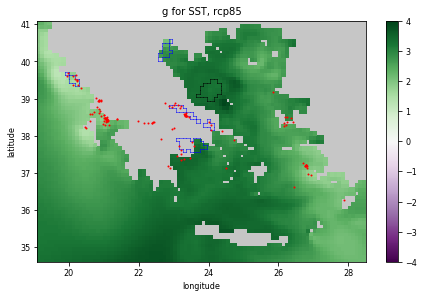

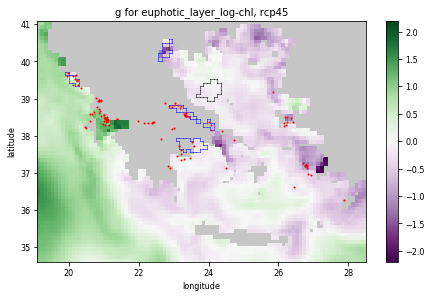

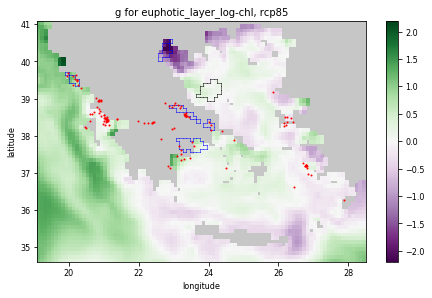

In [21]:
vblist = ['SST','euphotic_layer_log-chl']

# location of shapefiles
shapedir = '../../data/MSP/shapefiles'

# name  of region 
reg_name = 'Greece'

# file with data for processing
gfilename = outdir+'/%s_Hedges-g.nc' % (reg_name)

# model scenarios
run_list = ['rcp85','rcp45']

# fill value used for masked data
fv = default_fillvals['f8']

# list of MPAs to plot and names of shapefiles
mpa_list ={'Alonissos':'WDPA_Apr2018_protected_area_555527014-shapefile-polygons','Karpathos':'Export_Output','Zakynthos':'Park_boundary'}

# list of fishing grounds to plotting
fish_list = {'Eviokos':'polygons3','Kerkyraikos_Gulf':'polygons4','N_Aegean_plateau':'polygons1','Saronikos':'polygons2'}

# file with list of aquaculture points
aqua_list_file = shapedir+'/Aquaculture_dec_degs_JLM.csv'

# open file with g values, saved in step 3, and read grid info
nc = Dataset(gfilename,'r')
lon = nc.variables['lon'][:]
lat = nc.variables['lat'][:]

# read MPA masks
mpa_masks = read_area_masks(mpa_list,shapedir,lon,lat)

# read fishing ground masks
fish_masks = read_area_masks(fish_list,shapedir,lon,lat)

# read location of aquaculture sites
aqsites = genfromtxt(aqua_list_file,skip_header=1,delimiter=',')

# set figure size and other parameters for plotting
figsize = (7.6, 5.0)
# preferred color scheme
color_map = {'g':'PRGn'}
# font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title        

# set range to use for plotting
vmax = {'SST':4.0,'euphotic_layer_log-chl':2.2}

for vbname in vblist:
    for run in ['rcp45','rcp85']:
        print('Plotting',vbname,run)
        # read g from file
        vbdat = nc.variables['%s_g_%s' % (vbname,run,)][:]
        g = masked_where(vbdat==fv,vbdat)
        # set up plot
        fig,ax = plt.subplots(nrows=1,ncols=1,figsize=figsize)
        fig.subplots_adjust(top=0.85,bottom=0.18,left=0.15)
        # plot g
        ax.set_xlim(lon.min(),lon.max())
        ax.set_ylim(lat.min(),lat.max())
        ax.set_xlabel('longitude')
        ax.set_ylabel('latitude')
        im_mask = ax.pcolormesh(lon,lat,g.mask,cmap='Greys',vmax=3)
        im = ax.pcolormesh(lon,lat,g,cmap=color_map['g'],vmin=-vmax[vbname],vmax=vmax[vbname])
        # plot MPAs
        for mpa in list(mpa_list.keys()):
            try:
                segments = get_mask_outline(mpa_masks[mpa])
                ax.plot(segments[:,0], segments[:,1], color='k', linewidth=0.5)
            except:
                "Could not plot",mpa
        # plot fishing grounds
        for fgrnd in fish_list:
            segments = get_mask_outline(fish_masks[fgrnd])
            ax.plot(segments[:,0], segments[:,1], color='b', linewidth=0.5)
        # plot points with aquaculture sites
        ax.plot(aqsites[:,1],aqsites[:,0],'ro',ms=1,mec='r')
        cb = fig.colorbar(im,ax=ax)
        ax.set_title('g for %s, %s' % (vbname, run))
        fig.savefig('%s_g+MPAs-fishing_%s_%s.png' % (reg_name,vbname,run),dpi=150)
nc.close()